# First attempt with keras/tf

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.debugger import set_trace as st
from sklearn.model_selection import train_test_split

print(tf.__version__)

1.10.0


## Dataset: ISO-SWS

In [2]:
# Needed directories
base_dir = '../data/isosws_atlas/'

# Pickles containing our spectra in the form of pandas dataframes:
spec_dir = base_dir + 'spectra/'
spec_files = np.sort(glob.glob(spec_dir + '*.pkl'))

# Metadata pickle (pd.dataframe). Note each entry contains a pointer to the corresponding spectrum pickle.
metadata = base_dir + 'metadata.pkl'

In [3]:
# Load the metadata pickle.
meta = pd.read_pickle(metadata)

In [4]:
meta

,object_name,tdt,ra,dec,full_classifier,group,subgroup,uncertainty_flag,note,,file_path,object_type,data_ok
0,W Cet,37802225,0.532083,-14.676639,2.SEa:,2,SEa,1,,,spectra/37802225_sws.pkl,S*,True
1,SV And,42801007,1.083333,40.110333,2.SEa:,2,SEa,1,,,spectra/42801007_sws.pkl,Mira,True
2,SV And,80800708,1.083333,40.110333,2.SEa,2,SEa,,,,spectra/80800708_sws.pkl,Mira,True
3,CIT 1,78201008,1.717917,43.076667,7,7,,,W,,spectra/78201008_sws.pkl,Mira,True
4,HR 10,37802001,1.825833,-17.387000,1.NM:,1,NM,1,,,spectra/37802001_sws.pkl,Star,True
5,{beta} Cas,28501420,2.293625,59.149944,1.N,1,N,,,,spectra/28501420_sws.pkl,Star,True
6,V633 Cas,43501514,2.860833,58.834444,5.SE,5,SE,,W,,spectra/43501514_sws.pkl,Ae*,True
7,NGC 40,44401917,3.253792,72.522222,4.PN,4,PN,,,,spectra/44401917_sws.pkl,PN,True
8,NGC 40,30003803,3.254583,72.521972,4.PN,4,PN,,,,spectra/30003803_sws.pkl,PN,True
9,HR 48,55502138,3.660000,-18.932889,1.NO,1,NO,,,,spectra/55502138_sws.pkl,Candidate_LP*,True


### Labels

In [53]:
# Simple classifier first.
labels = meta['group'].values.astype(int)

In [54]:
# The possible labels.
np.unique(labels)

array([1, 2, 3, 4, 5, 6, 7])

In [55]:
# SHIFTING TO START AT ZERO!
labels = labels - 1

#### Labels ('group'):

1. Naked stars
2. Stars with dust
3. Warm, dusty objects
4. Cool, dusty objects
5. Very red objects
6. Continuum-free objects but having emission lines
7. Flux-free and/or fatally flawed spectra

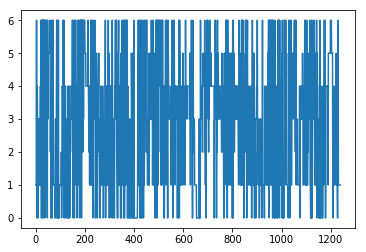

In [56]:
# See how the labels are distributed.
plt.plot(labels);

In [8]:
# Shuffle data at some point.

In [40]:
type(labels[0])

numpy.int64

In [41]:
# Make sure each sample has a valid label.
np.sum(np.isfinite(labels)) == len(labels)

True

In [42]:
len(labels)

1239

In [15]:
# knowing that each sample has a 359-point vector/spectrum.
features = np.zeros((len(labels), 359))

### Features

In [16]:
def load_spectrum(path):
    df = pd.read_pickle(path)
    return df['flux']

index = 0
# Fill the 'spectra' variable with the astronomical data.
for row in meta.itertuples(index=True, name='Pandas'):
    flux = load_spectrum(base_dir + row.file_path)
    features[index] = flux
    index += 1

In [17]:
features.shape

(1239, 359)

# Split into training and test sets

Data as...
- feaatures (1239, 359)
- labels (1239)

In [57]:
X_train, X_test, y_train, y_test = \
train_test_split(features, labels, test_size=0.33, random_state = 42)

In [58]:
X_train.shape

(830, 359)

In [59]:
X_test.shape

(409, 359)

In [60]:
y_train.shape

(830,)

In [61]:
y_test.shape

(409,)

# Model 1. NN

In [99]:
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(keras.layers.Dense(64, activation='relu'))
# Add another:
model.add(keras.layers.Dense(64, activation='relu'))
# Add another:
model.add(keras.layers.Dense(64, activation='relu'))
# Add another:
model.add(keras.layers.Dense(32, activation='relu'))
# Add a softmax layer with 7 output units:
model.add(keras.layers.Dense(7, activation='softmax'))

In [104]:
model.compile(optimizer=tf.train.AdamOptimizer(0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [105]:
# # Configure a model for categorical classification.
# model.compile(optimizer=tf.train.RMSPropOptimizer(0.001),
#               loss=keras.losses.sparse_categorical_crossentropy,
#               metrics=[keras.metrics.categorical_accuracy])

In [106]:
model.fit(features, labels, epochs=100, batch_size=32)

Epoch 1/100
1239/1239 [==============================] - 0s 333us/step - loss: 0.4431 - acc: 0.8846
Epoch 2/100
1239/1239 [==============================] - 0s 65us/step - loss: 0.3719 - acc: 0.9104
Epoch 3/100
1239/1239 [==============================] - 0s 66us/step - loss: 0.3193 - acc: 0.9282
Epoch 4/100
1239/1239 [==============================] - 0s 61us/step - loss: 0.4095 - acc: 0.9144
Epoch 5/100
1239/1239 [==============================] - 0s 66us/step - loss: 0.4829 - acc: 0.8967
Epoch 6/100
1239/1239 [==============================] - 0s 60us/step - loss: 0.3412 - acc: 0.9153
Epoch 7/100
1239/1239 [==============================] - 0s 62us/step - loss: 0.5065 - acc: 0.8983
Epoch 8/100
1239/1239 [==============================] - 0s 65us/step - loss: 0.4157 - acc: 0.9040
Epoch 9/100
1239/1239 [==============================] - 0s 67us/step - loss: 0.4287 - acc: 0.9185
Epoch 10/100
1239/1239 [==============================] - 0s 66us/step - loss: 0.6894 - acc: 0.8846
Epoch 11

1239/1239 [==============================] - 0s 58us/step - loss: 0.3437 - acc: 0.9144
Epoch 84/100
1239/1239 [==============================] - 0s 63us/step - loss: 0.5437 - acc: 0.9072
Epoch 85/100
1239/1239 [==============================] - 0s 64us/step - loss: 0.3849 - acc: 0.9056
Epoch 86/100
1239/1239 [==============================] - 0s 60us/step - loss: 0.3164 - acc: 0.9266
Epoch 87/100
1239/1239 [==============================] - 0s 60us/step - loss: 0.9781 - acc: 0.8612
Epoch 88/100
1239/1239 [==============================] - 0s 63us/step - loss: 2.3682 - acc: 0.7369
Epoch 89/100
1239/1239 [==============================] - 0s 64us/step - loss: 2.0092 - acc: 0.7724
Epoch 90/100
1239/1239 [==============================] - 0s 64us/step - loss: 1.6592 - acc: 0.7716
Epoch 91/100
1239/1239 [==============================] - 0s 68us/step - loss: 1.5139 - acc: 0.7966
Epoch 92/100
1239/1239 [==============================] - 0s 64us/step - loss: 0.4996 - acc: 0.8684
Epoch 93/100


#### Test accuracy

In [107]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

409/409 [==============================] - 0s 331us/step
Test accuracy: 0.9095354520312732


#### Check predictions

In [108]:
predictions = model.predict(X_test)

In [112]:
predicted_groups = [np.argmax(x) for x in predictions]

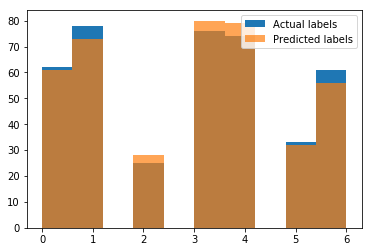

In [127]:
plt.hist(y_test, label='Actual labels');
plt.hist(predicted_groups, label='Predicted labels', alpha=0.7);
plt.legend(loc=0)

# Model 2. stochastic gradient descent

http://scikit-learn.org/stable/modules/sgd.html

In [128]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2")
clf.fit(X_train, y_train)
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

/home/koma/miniconda3/envs/tf/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [130]:
predicted_labels = clf.predict(X_test)

In [134]:
test_acc = np.sum(predicted_labels == y_test) / len(y_test)

In [135]:
print('Test accuracy:', test_acc)

Test accuracy: 0.530562347188264


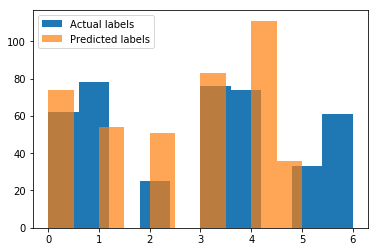

In [136]:
plt.hist(y_test, label='Actual labels');
plt.hist(predicted_labels, label='Predicted labels', alpha=0.7);
plt.legend(loc=0)